# Integrantes:  
Gaston Arida, Sebastian Ferreiro, Jeronimo Vernay

---

# Contenidos:

En este archivo se encuentran los códigos correspondientes a las consultas SQL solicitadas en el enunciado. Por otro lado, se encuentran los códigos que gue generan las imágenes pertenecientes a la sección de visualización y análisis de datos. Los archivos utilizados en esta sección corresponden a las relaciones del modelo realacional y fueron previamente modificados. El código utilizado para generar estos archivos se encientra en el archivo "Limpieza_de_archivos".

Nota: Este archivo fue originalmente creado en Jupyter Notebook por lo que recomendamos leerlo en este mismo formato.

---

# Leemos los archivos del Modelo relacional:

In [2]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

BP = pd.read_csv("TablasModelo\\BP_limpio.csv")                          
EE = pd.read_csv("TablasModelo\\EE_limpio.csv")
Provincia = pd.read_csv("TablasModelo\\Provincia.csv")
Departamento = pd.read_csv("TablasModelo\\Departamento.csv")
Poblacion = pd.read_csv("TablasModelo\\Padron_limpio.csv")

---

# Consultas SQL en base al modelo relacional:

Primero registramos los nombres para hacer las consultas:

In [3]:
duckdb.register("EE", EE)
duckdb.register("Poblacion", Poblacion)
duckdb.register("Departamento", Departamento)
duckdb.register("Provincia", Provincia)  
duckdb.register("BP", BP)

# Primer consulta

"Para cada departamento informar la provincia, el nombre del departamento,
la cantidad de EE de cada nivel educativo, considerando solamente la
modalidad común, y la cantidad de habitantes por edad según los niveles
educativos. El orden del reporte debe ser alfabético por provincia y dentro de
las provincias, descendente por cantidad de escuelas primarias."

In [4]:
# Tenemos problemas a la hora de contar a las personas, ya que nos da un numero irreal.
# Si un departamento tiene varios EE y BP, entonces si hacemos una consulta tradicional, multiplica los 
# 8 rango etarios por la cant. BP y cant. EE que hay en dicho departamento (8 x BP x EE) dando un numero irreal

# Solucionamos dicho problema, que se repite en la consulta 3, haciendo subconsultas previas que agreguen la 
# informacion primero y luego hacemos los Joins.


consulta1 = """

-- 1) Contamos los EE por tipo y por departamento
-- Utilizamos Cueanexo como identificador unico de cada Establecimiento 
WITH ee_por_departamento AS (
    SELECT 
        id_departamento,
        COUNT(CASE WHEN Jardin > 0 THEN Cueanexo END) AS jardines,
        COUNT(CASE WHEN Primario > 0 THEN Cueanexo END) AS primarias,
        COUNT(CASE WHEN Secundario > 0 THEN Cueanexo END) AS secundarios
    FROM EE
    GROUP BY id_departamento
),

-- 2) Calculo la poblacion por niveles educativos (por ejem: 3 a 5 es Jardin) con ayuda de la separacion
-- hecha por Rango Etario
poblacion_por_departamento AS (
    SELECT 
        id_departamento,
        SUM(CASE WHEN "Rango etario" = '3 a 5' THEN casos ELSE 0 END) AS poblacion_jardin,
        SUM(CASE WHEN "Rango etario" = '6 a 11' THEN casos ELSE 0 END) AS poblacion_primaria,
        SUM(CASE WHEN "Rango etario" = '12 a 18' THEN casos ELSE 0 END) AS poblacion_secundaria
    FROM Poblacion
    GROUP BY id_departamento
)

-- 3) Consulta que une los datos, como se muestra en la tabla de ejemplo
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,

    COALESCE(ee.jardines, 0) AS jardines,
    COALESCE(pob.poblacion_jardin, 0) AS poblacion_jardin,

    COALESCE(ee.primarias, 0) AS primarias,
    COALESCE(pob.poblacion_primaria, 0) AS poblacion_primaria,

    COALESCE(ee.secundarios, 0) AS secundarios,
    COALESCE(pob.poblacion_secundaria, 0) AS poblacion_secundaria


-- 4) Indicamos los valores que queremos como generales y hacemos LEFT JOIN para incluir todo
-- Ordenamos como pide el enunciado.
FROM Departamento dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN ee_por_departamento ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_departamento pob ON dept.id_departamento = pob.id_departamento

ORDER BY prov.nombre ASC, primarias DESC;
"""

resultado1 = duckdb.query(consulta1).to_df()
print(f"resultados 1: {resultado1}")

resultados 1:         provincia        departamento  jardines  poblacion_jardin  primarias  \
0    Buenos Aires          LA MATANZA       333           87162.0        335   
1    Buenos Aires            LA PLATA       234           29260.0        201   
2    Buenos Aires     LOMAS DE ZAMORA       170           28806.0        179   
3    Buenos Aires  GENERAL PUEYRREDON       178           23100.0        168   
4    Buenos Aires             QUILMES       160           26975.0        145   
..            ...                 ...       ...               ...        ...   
523       Tucumán             TRANCAS        25            1163.0         25   
524       Tucumán      TAFI DEL VALLE        22            1010.0         24   
525       Tucumán            FAMAILLA        24            2322.0         23   
526       Tucumán      JUAN B ALBERDI        20            1586.0         19   
527       Tucumán            LA COCHA        17             992.0         18   

     poblacion_primaria  

# Segunda consulta

"Para cada departamento informar la provincia, el nombre del departamento y
la cantidad de BP fundadas desde 1950. El orden del reporte debe ser
alfabético por provincia y dentro de las provincias, descendente por cantidad de BP de dicha capacidad."

In [5]:
consulta2 = """
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,
    COUNT(*) AS Cant_BP_fundadas_desde_1950     -- Conteo de las BP's que cumplen condicion


-- Hacemos los JOIN's usando el modelo del enunciado
FROM BP bp
JOIN Departamento dept ON bp.id_departamento = dept.id_departamento
JOIN Provincia prov ON dept.id_provincia = prov.id

-- Como las fechas estan indexadas como año-mes-dia, buscamos solamente los primeros 4 numeros
-- fecha_fundacion es dtype object, por lo que convertimos a los primeros 4 chars en numero y lo comparamos con 1950
-- En SQL la primera posicion es 1, no 0.
WHERE 
    TRY_CAST(SUBSTR(bp.fecha_fundacion, 1, 4) AS INTEGER) >= 1950

-- Agrupamos como pide el enunciado 
GROUP BY prov.nombre, dept.Departamento
ORDER BY prov.nombre ASC, Cant_BP_fundadas_desde_1950 DESC;
"""

resultado2 = duckdb.query(consulta2).to_df()
print(f"resultados 2: {resultado2}")

resultados 2:         provincia    departamento  Cant_BP_fundadas_desde_1950
0    Buenos Aires      LA MATANZA                           15
1    Buenos Aires        LA PLATA                           15
2    Buenos Aires          MORENO                           13
3    Buenos Aires    BAHIA BLANCA                           12
4    Buenos Aires           TIGRE                           12
..            ...             ...                          ...
358       Tucumán  TAFI DEL VALLE                            1
359       Tucumán     CHICLIGASTA                            1
360       Tucumán     YERBA BUENA                            1
361       Tucumán      TAFI VIEJO                            1
362       Tucumán       RIO CHICO                            1

[363 rows x 3 columns]


# Tercer consulta

"Para cada departamento, indicar provincia, nombre del departamento,
cantidad de BP, cantidad de EE (de modalidad común) y población total.
Ordenar por cantidad EE descendente, cantidad BP descendente, nombre de 
provincia ascendente y nombre de departamento ascendente. No omitir casos sin BP o EE."

In [6]:
consulta3 = """
-- Creamos las Tablas temporales

-- 1) Contamos las BP unicas por departamento
WITH bp_por_dpto AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT nro_conabip) AS cantidad_bp      -- Usamos nro_conabip como identificador unico (nuestra PK)
    FROM BP
    GROUP BY id_departamento
),

-- 2) Contamos los EE unico por departamento
ee_por_dpto AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT Cueanexo) AS cantidad_ee     -- Usamos Cueanexo como identificador unico (nuestra PK)
    FROM EE
    GROUP BY id_departamento
),

-- 3) Al estar dividido en rango etario, sumamos cada "caso" para encontrar el poblacion_total
poblacion_por_dpto AS (
    SELECT 
        id_departamento,
        SUM(casos) AS poblacion_total
    FROM Poblacion
    GROUP BY id_departamento
)

-- 4) Consulta tradicional
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,
    COALESCE(bp.cantidad_bp, 0) AS cantidad_bp,         -- 0 si no hay BP
    COALESCE(ee.cantidad_ee, 0) AS cantidad_ee,         -- 0 si no hay EE
    COALESCE(pob.poblacion_total, 0) AS poblacion_total 

-- Pedimos el departamento con su provincia y hacemos LEFT JOIN para no excluir los datos que no tengan BP o EE
FROM Departamento dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN bp_por_dpto bp ON dept.id_departamento = bp.id_departamento
LEFT JOIN ee_por_dpto ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_dpto pob ON dept.id_departamento = pob.id_departamento

ORDER BY cantidad_ee DESC, cantidad_bp DESC, prov.nombre ASC, dept.Departamento ASC;
"""

resultado3 = duckdb.query(consulta3).to_df()
print(f"resultados 3: {resultado3}")

resultados 3:             provincia         departamento  cantidad_bp  cantidad_ee  \
0             Córdoba              CAPITAL           20         1418   
1            Santa Fe              ROSARIO           39         1277   
2        Buenos Aires           LA MATANZA           16         1201   
3        Buenos Aires             LA PLATA           33          859   
4               Chaco         SAN FERNANDO           31          805   
..                ...                  ...          ...          ...   
523          La Pampa        LIMAY MAHUIDA            0            5   
524          La Pampa         LIHUEL CALEL            1            4   
525          La Rioja            SANAGASTA            1            3   
526            Chubut             MARTIRES            0            3   
527  Tierra del Fuego  ANTARTIDA ARGENTINA            0            0   

     poblacion_total  
0          1498060.0  
1          1337958.0  
2          1837168.0  
3           756074.0  
4     

# Cuarta consulta

"Para cada departamento, indicar provincia, el nombre del departamento y
qué dominios de mail se usan más para las BP."

In [7]:
consulta4 = """
SELECT provincia, departamento,
        /* Agaro solo el nombre principal del dominio (sin el .com)) */ 
       SPLIT_PART(dominio_mas_frecuente, '.', 1) AS dominio_principal
FROM (
  SELECT provincia, departamento, dominio AS dominio_mas_frecuente
  FROM (
    SELECT 
      prov.nombre AS provincia,
      dept.Departamento AS departamento,
      SPLIT_PART(bp.mail, '@', 2) AS dominio,   -- Agarro la parte después del @ 
      COUNT(*) AS count,    -- Cuenta repeticiones de cada dominio 
      ROW_NUMBER() OVER (
        PARTITION BY dept.id_departamento  -- Agrupo por departamento 
        ORDER BY COUNT(*) DESC  -- Ordeno dominios de mayor a menor 
      ) AS nro_fila -- La primer fila sera la mas frecuente 
    FROM BP bp
    JOIN Departamento dept ON bp.id_departamento = dept.id_departamento
    JOIN Provincia prov ON dept.id_provincia = prov.id
    WHERE bp.mail IS NOT NULL AND bp.mail LIKE '%@%'                        -- Filtro mails válidos 
    GROUP BY prov.nombre, dept.Departamento, dept.id_departamento, dominio
  ) cierro_parentesis   -- esto es obligatorio para finalizar la subconsulta 
  WHERE nro_fila = 1
) resultado         -- esto tambien es obligatorio para la sintaxis de SQL
"""

resultado4 = duckdb.query(consulta4).to_df()
print(f"resultados 4: {resultado4}")

resultados 4:       provincia               departamento dominio_principal
0    Corrientes              CURUZU CUATIA             gmail
1    Corrientes              MONTE CASEROS           hotmail
2         Chaco                 9 DE JULIO           hotmail
3    Entre Ríos                    FEDERAL             gmail
4    Entre Ríos                    URUGUAY             yahoo
..          ...                        ...               ...
319     Mendoza                  RIVADAVIA           hotmail
320     Mendoza                    TUNUYAN             yahoo
321    Misiones  LIBERTADOR GRL SAN MARTIN             yahoo
322    Misiones                SAN IGNACIO             gmail
323     Neuquén                      MINAS             yahoo

[324 rows x 3 columns]


---

# Gráficos:

# Primer gráfico

"Cantidad de BP por provincia. Mostrarlos ordenados de manera decreciente
por dicha cantidad."

C:\Users\Dell\AppData\Local\Temp\ipykernel_6396\3980054854.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico


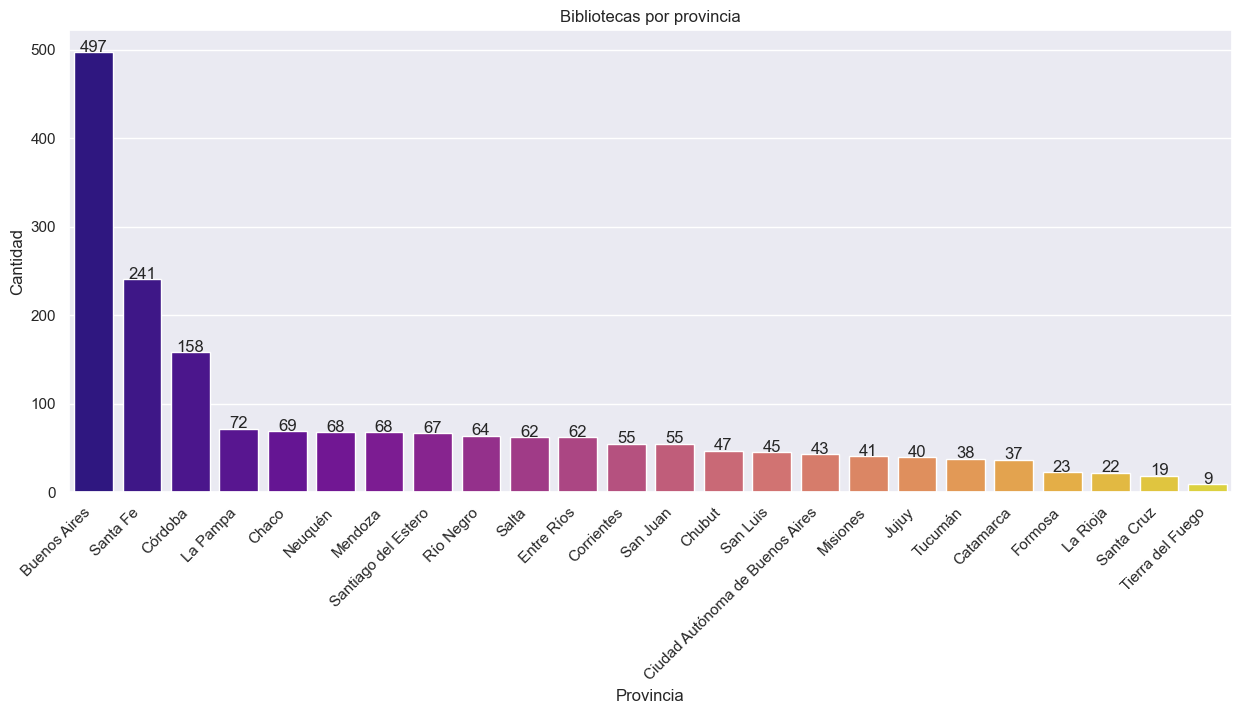

In [8]:
provincias = BP['provincia'].unique()

diccionario = {}
for provincia in provincias:
    diccionario[provincia] = len(BP.loc[BP['provincia'] == provincia])

# Creamos listas separadas para cada columna
provincias = list(diccionario.keys())
cantidad = list(diccionario.values())

# DataFrame con columnas
df = pd.DataFrame({
    'Provincia': provincias,
    'Cantidad': cantidad
})

df = df.sort_values(by='Cantidad', ascending=False) #ordeno las provincias por cantidad de bibliotecas de manera decreciente

sns.set(
    rc = {"figure.figsize": (15, 6)}
)  # Configuracion del ancho y largo del grafico para que se vea mejor

ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico

plt.xticks(rotation=45, ha="right")  # Rotación y alineación del texto para que se puedan ver el nombre de cada una de las provincias

plt.title("Bibliotecas por provincia") # Titulo del grafico

for i, valor in enumerate(df["Cantidad"]):
    ax.text(i, valor + 0.5, str(valor), ha="center", fontsize=12)  # Usamos esto para poner el numero arriba de cada barra, asi es mas claro

plt.show()

#usamos la paleta plasma, ya que es amigable pora personas con daltonismo  (protanopia y deuteranopia)

# Segundo gráfico

"Graficar la cantidad de EE de los departamentos en función de la población,
separando por nivel educativo y su correspondiente grupo etario
(identificándolos por colores). Se pueden basar en la primera consulta SQL
para realizar este gráfico."

Nota: En el caso de este gráfico tenemos más de una versión para mostrar ya que tienen distintos enfoques. Primero veremos un heatmap en el cuál la intuición visual ayuda a distinguir las propociones pero no es tan claro en cuanto a las cantidades reales de alumnos por EE. En la segunda versión veremos un gráfico de barras con los valores reales.

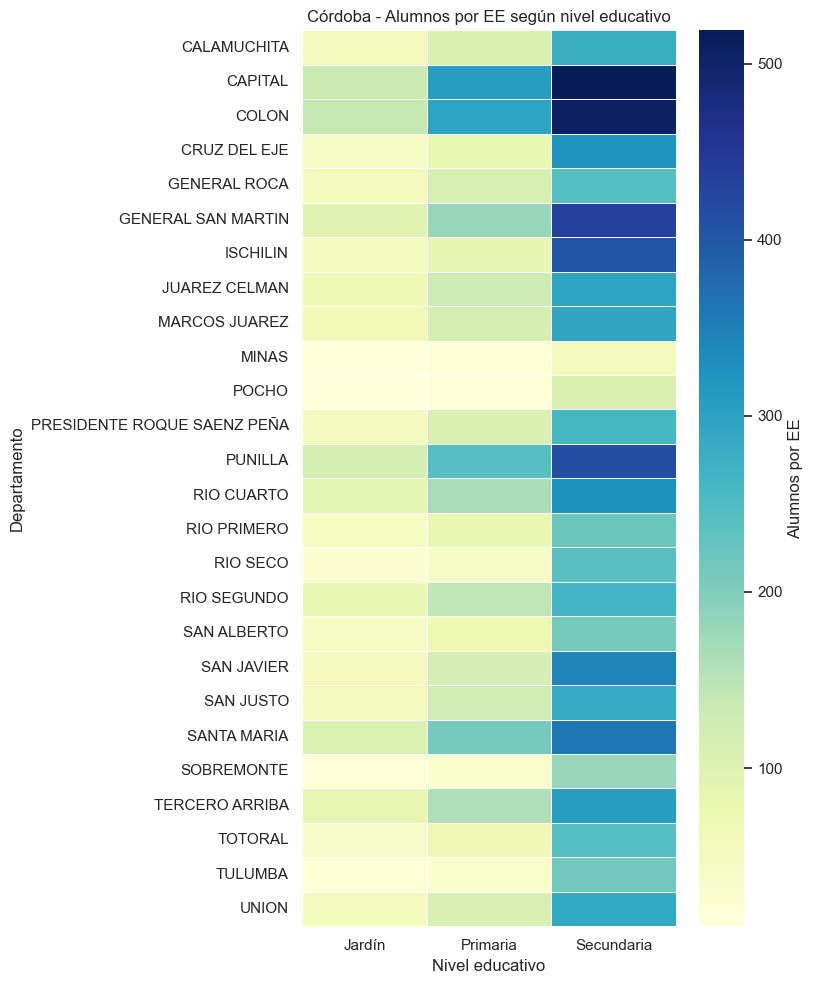

In [9]:
consulta_1 = pd.read_csv("ConsultasSQL\\Consulta_1.csv")                                            # Leemos el archivo consulta_1
consulta_1.columns = consulta_1.columns.str.strip().str.lower()

provincia = "Córdoba"                                                                               # Si cambiamos este nombre cambia el grafico
                                                                                                    # En la carpeta Graficos->grafico_2 se encuentran
                                                                                                    # todas las provincias
df_prov = consulta_1[consulta_1["provincia"] == provincia].copy()


df_prov["alumnos_por_jardin"] = df_prov["poblacion_jardin"] / df_prov["jardines"]                   # Calculamos los alumnos por EE segun nivel
df_prov["alumnos_por_primaria"] = df_prov["poblacion_primaria"] / df_prov["primarias"]
df_prov["alumnos_por_secundaria"] = df_prov["poblacion_secundaria"] / df_prov["secundarios"]


df_prov.replace([float("inf"), float("-inf")], pd.NA, inplace=True)                                 # Aqui limpiamos datos invalidos como la antartida
df_prov.dropna(subset=["alumnos_por_jardin", "alumnos_por_primaria", "alumnos_por_secundaria"], inplace=True)


df_long = df_prov.melt(                                                                             # Cambiamos el formato
    id_vars=["departamento"],
    value_vars=["alumnos_por_jardin", "alumnos_por_primaria", "alumnos_por_secundaria"],
    var_name="nivel",
    value_name="alumnos_por_ee"
)


df_long["nivel"] = df_long["nivel"].replace({                                                       # Renombramos las columnas para armar el grafico
    "alumnos_por_jardin": "Jardín", 
    "alumnos_por_primaria": "Primaria",
    "alumnos_por_secundaria": "Secundaria"
})

plt.figure(figsize=(8, 10))                                                                         # Creamos el HeatMap
sns.heatmap(
    df_long.pivot(index="departamento", columns="nivel", values="alumnos_por_ee"),
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Alumnos por EE"},
    annot=False
)
plt.title(f"{provincia} - Alumnos por EE según nivel educativo")                                    # Agregamos el titulo 
plt.xlabel("Nivel educativo")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

# Otra versión:

In [10]:
import plotly.graph_objects as go

provincia = "Tucumán"                                               # Si cambiamos este nombre podemos ver el grafico de cualquier provincia


consulta_1["chicos_por_jardin"] = consulta_1["poblacion_jardin"] / consulta_1["jardines"]       # Calculamos los valores correspondientes
consulta_1["chicos_por_primaria"] = consulta_1["poblacion_primaria"] / consulta_1["primarias"]
consulta_1["chicos_por_secundaria"] = consulta_1["poblacion_secundaria"] / consulta_1["secundarios"]


filtro = consulta_1[consulta_1["provincia"] == provincia]           # Filtramos los de la determinada provincia
departamentos = filtro["departamento"]

colores = {                                                         # Elejimos los colores para nuestro grafico
    "Jardín": "#E69F00",    
    "Primaria": "#56B4E9",
    "Secundaria": "#009E73"
}

fig = go.Figure()                                                   # Creamos el grafico con las divisiones por nivel educativo

for nivel, columna in zip(["Jardín", "Primaria", "Secundaria"],
                          ["chicos_por_jardin", "chicos_por_primaria", "chicos_por_secundaria"]):
    fig.add_trace(go.Bar(
        x=departamentos,
        y=filtro[columna],
        name=nivel,
        marker_color=colores[nivel],
        offsetgroup=nivel,
        legendgroup=nivel
    ))

fig.update_layout(                                                  # Ajustamos el formato, sobre todo porque la provincia de Buenos Aires tiene
    title=f"Cantidad de chicos por EE en {provincia}",              # 135 partidos
    xaxis_title="Departamento",
    yaxis_title="Chicos por EE",
    xaxis_tickangle=-90,
    barmode='group',
    height=600,
    width=2200 if provincia == "Buenos Aires" else 1000
)
fig.show()

# Tercer gráfico

"Realizar un boxplot por cada provincia, de la cantidad de EE por cada
departamento de la provincia. Mostrar todos los boxplots en una misma
figura, ordenados por la mediana de cada provincia."

C:\Users\Dell\AppData\Local\Temp\ipykernel_6396\780610596.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Dell\AppData\Local\Temp\ipykernel_6396\780610596.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




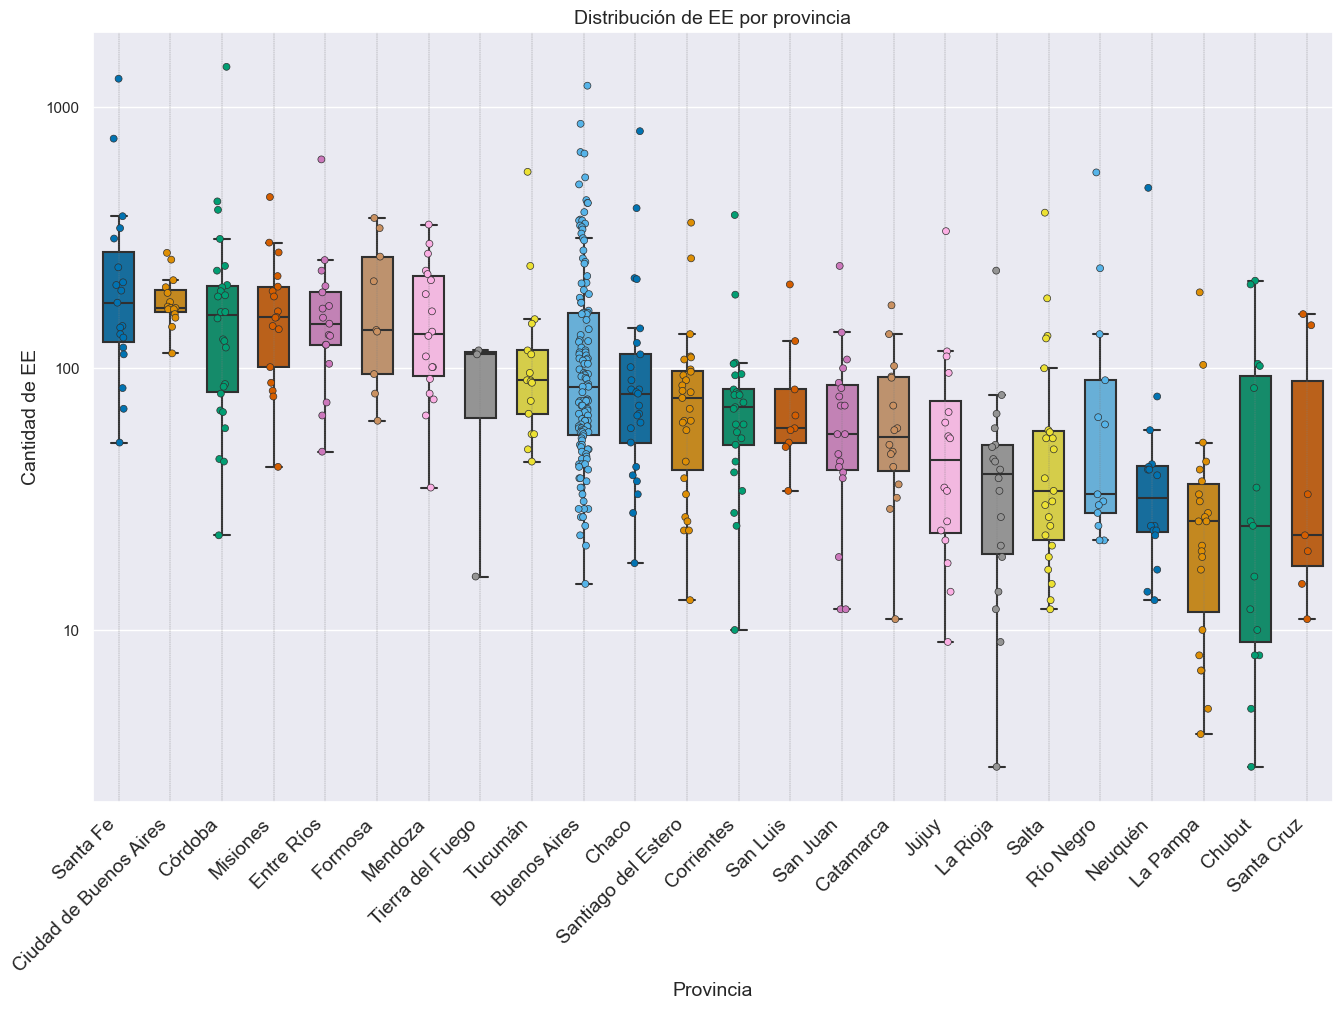

In [12]:
# Vamos a utilizar una consulta antes de graficar

Q_grafico = """
    SELECT EE.Departamento, nombre AS provincia, COUNT(EE.Departamento) AS cantidad 
    FROM EE JOIN  Departamento ON EE."id_departamento" = Departamento."id_departamento"
    JOIN Provincia ON Departamento."id_provincia" = Provincia."id"
    GROUP BY EE.Departamento, nombre
    ORDER BY cantidad DESC
"""

grafico = duckdb.query(Q_grafico).df()

# #ordena por mediana de provincia, de manera descendiente
provincia_orden = (
    grafico.groupby("provincia")["cantidad"]
    .median()
    .sort_values(ascending=False)
    .index
)

#tamaño del grafico
plt.figure(figsize=(16,10))

# --- Boxplot ---
boxplot = sns.boxplot(
    data=grafico,
    x="provincia",
    y="cantidad",
    order=provincia_orden,
    palette="colorblind",
    width=0.6,
    showfliers=False,  # Ocultamos outliers (los mostramos con stripplot)
    linewidth=1.5
)

# # --- Stripplot ---
sns.stripplot(
    data=grafico,
    x="provincia",
    y="cantidad",
    order=provincia_orden,    # Agrupar por provincia
    palette="colorblind",     # Misma paleta que boxplot
    dodge=False,           
    alpha=1,
    size=5,
    linewidth=0.5,
    legend=False           # Oculta leyenda duplicada
)

# # para la escala del eje y
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')


# # --- Ajustes finales ---
plt.title("Distribución de EE por provincia", fontsize=14)
plt.xlabel("Provincia", fontsize=14)
plt.ylabel("Cantidad de EE", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=14)

# #lineas para que se entiende a que provincia pertenece cada boxplot
for i in range(len(provincia_orden)):
    plt.axvline(i, color='gray', linewidth=0.3, linestyle='--')
    
plt.show()


# Cuarto gráfico

"Relación entre la cantidad de BP cada mil habitantes y de EE cada mil
habitantes por departamento."

Nota:   En el caso de este gráfico también tenemos más de una versión para mostrar ya que nuevamente cada uno tiene un distinto enfoque. En la primer   figura tenemos un histograma donde veremos según la provincia, cómo la cantidad de EE cada mil habitantes va de menor a mayor y además tenemos una      regresión lineal para ver la tendencia de la cantidad de BPs cada mil habitantes. 
En el segundo caso tenemos por provincia, un scatter plot clásico donde el eje X representa la cantidad de BPs mientras que el eje Y representa la cantidad de EEs. También cuenta con regresión lineal para anlizar la tendencia.
El último gráfico muestra en escala logaritmica los 528 departamentos/partidos/comunas juntos donde se ve mucho más clara la relación entre ambos parámetros.

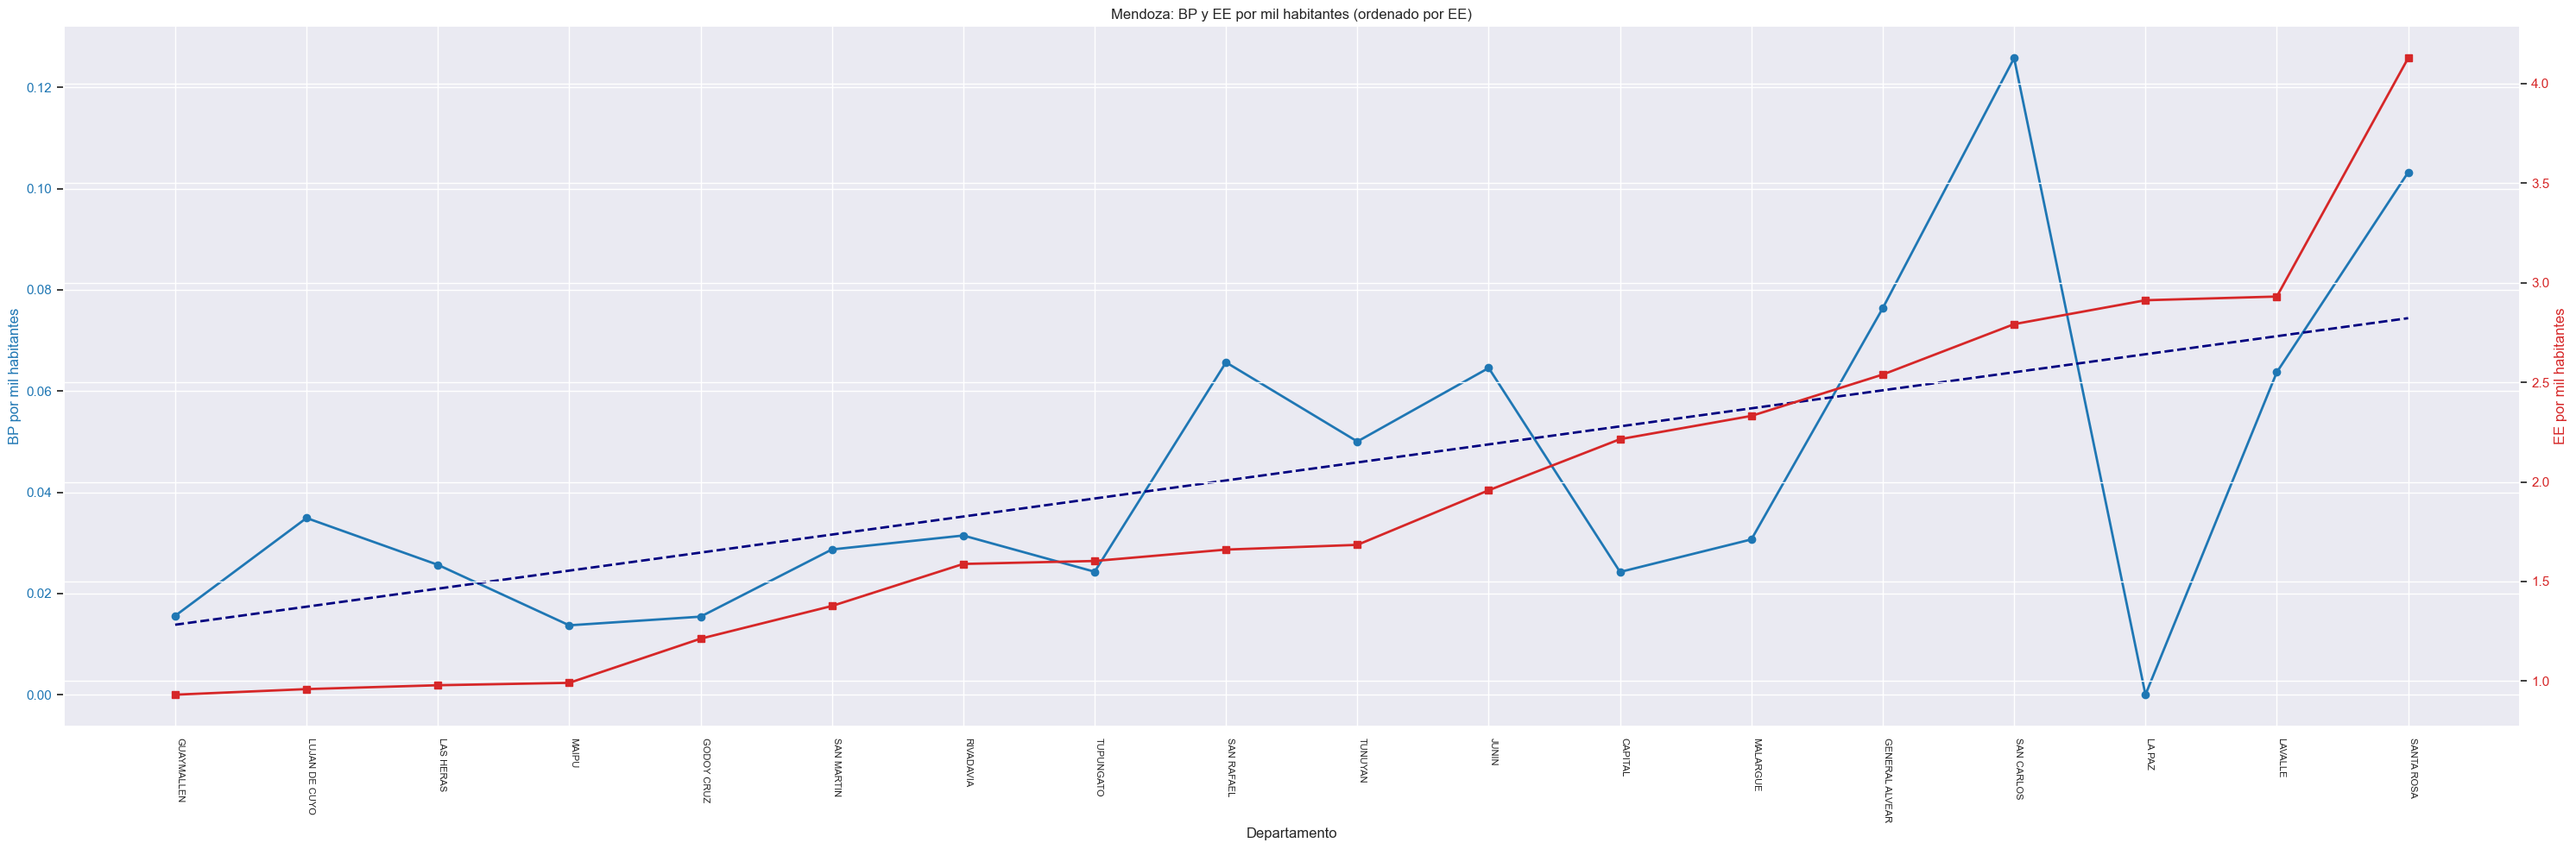

In [ ]:
from sklearn.linear_model import LinearRegression

prov = "Córdoba"                                                                            # Si cambiamos este valor cambia la provincia

consulta_3 = pd.read_csv("ConsultasSQL\\Consulta_3.csv")                                    # Leemos el archivo consulta 3
provincia = consulta_3[consulta_3['provincia'] == prov].copy()

provincia['bp_por_mil'] = provincia['cantidad_bp'] / provincia['poblacion_total'] * 1000    # Calculamos los valores
provincia['ee_por_mil'] = provincia['cantidad_ee'] / provincia['poblacion_total'] * 1000    

provincia_sorted = provincia.sort_values('ee_por_mil').reset_index(drop=True)               # Ordenamos por EE
x_pos = np.arange(0, len(provincia_sorted) * 2, 2).reshape(-1, 1) 

fig, ax1 = plt.subplots(figsize=(30, 10))                                                   # A partir de aqui graficamos

ax1.set_xlabel('Departamento')                                                              # Aqui la linea de BP
ax1.set_ylabel('BP por mil habitantes', color='tab:blue')
ax1.plot(x_pos, provincia_sorted['bp_por_mil'], color='tab:blue', marker='o', linewidth=2, label='BP por mil habitantes')
ax1.tick_params(axis='y', labelcolor='tab:blue')

model_bp = LinearRegression()                                                               # Utilizamos regresión lineal sobre BP
model_bp.fit(x_pos, provincia_sorted['bp_por_mil'])                                         # para facilitar la lectura de la tendencia
y_pred = model_bp.predict(x_pos)
ax1.plot(x_pos, y_pred, color='navy', linestyle='--', linewidth=2, label='Regresión lineal BP')

ax2 = ax1.twinx()                                                                           # Aquila linea de EE
ax2.set_ylabel('EE por mil habitantes', color='tab:red')
ax2.plot(x_pos, provincia_sorted['ee_por_mil'], color='tab:red', marker='s', linewidth=2, label='EE por mil habitantes')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_xticks(x_pos.flatten())                                                             # Ponemos las etiquetas a -90 grados para que se lean bien
ax1.set_xticklabels(provincia_sorted['departamento'], rotation=-90, ha='left', fontsize=8)

plt.subplots_adjust(bottom=0.3) 
plt.title(f'{prov}: BP y EE por mil habitantes (ordenado por EE)')                          # Ponemos el titulo                       
plt.tight_layout()
plt.show()

# Otras versiones con diferentes enfoques:

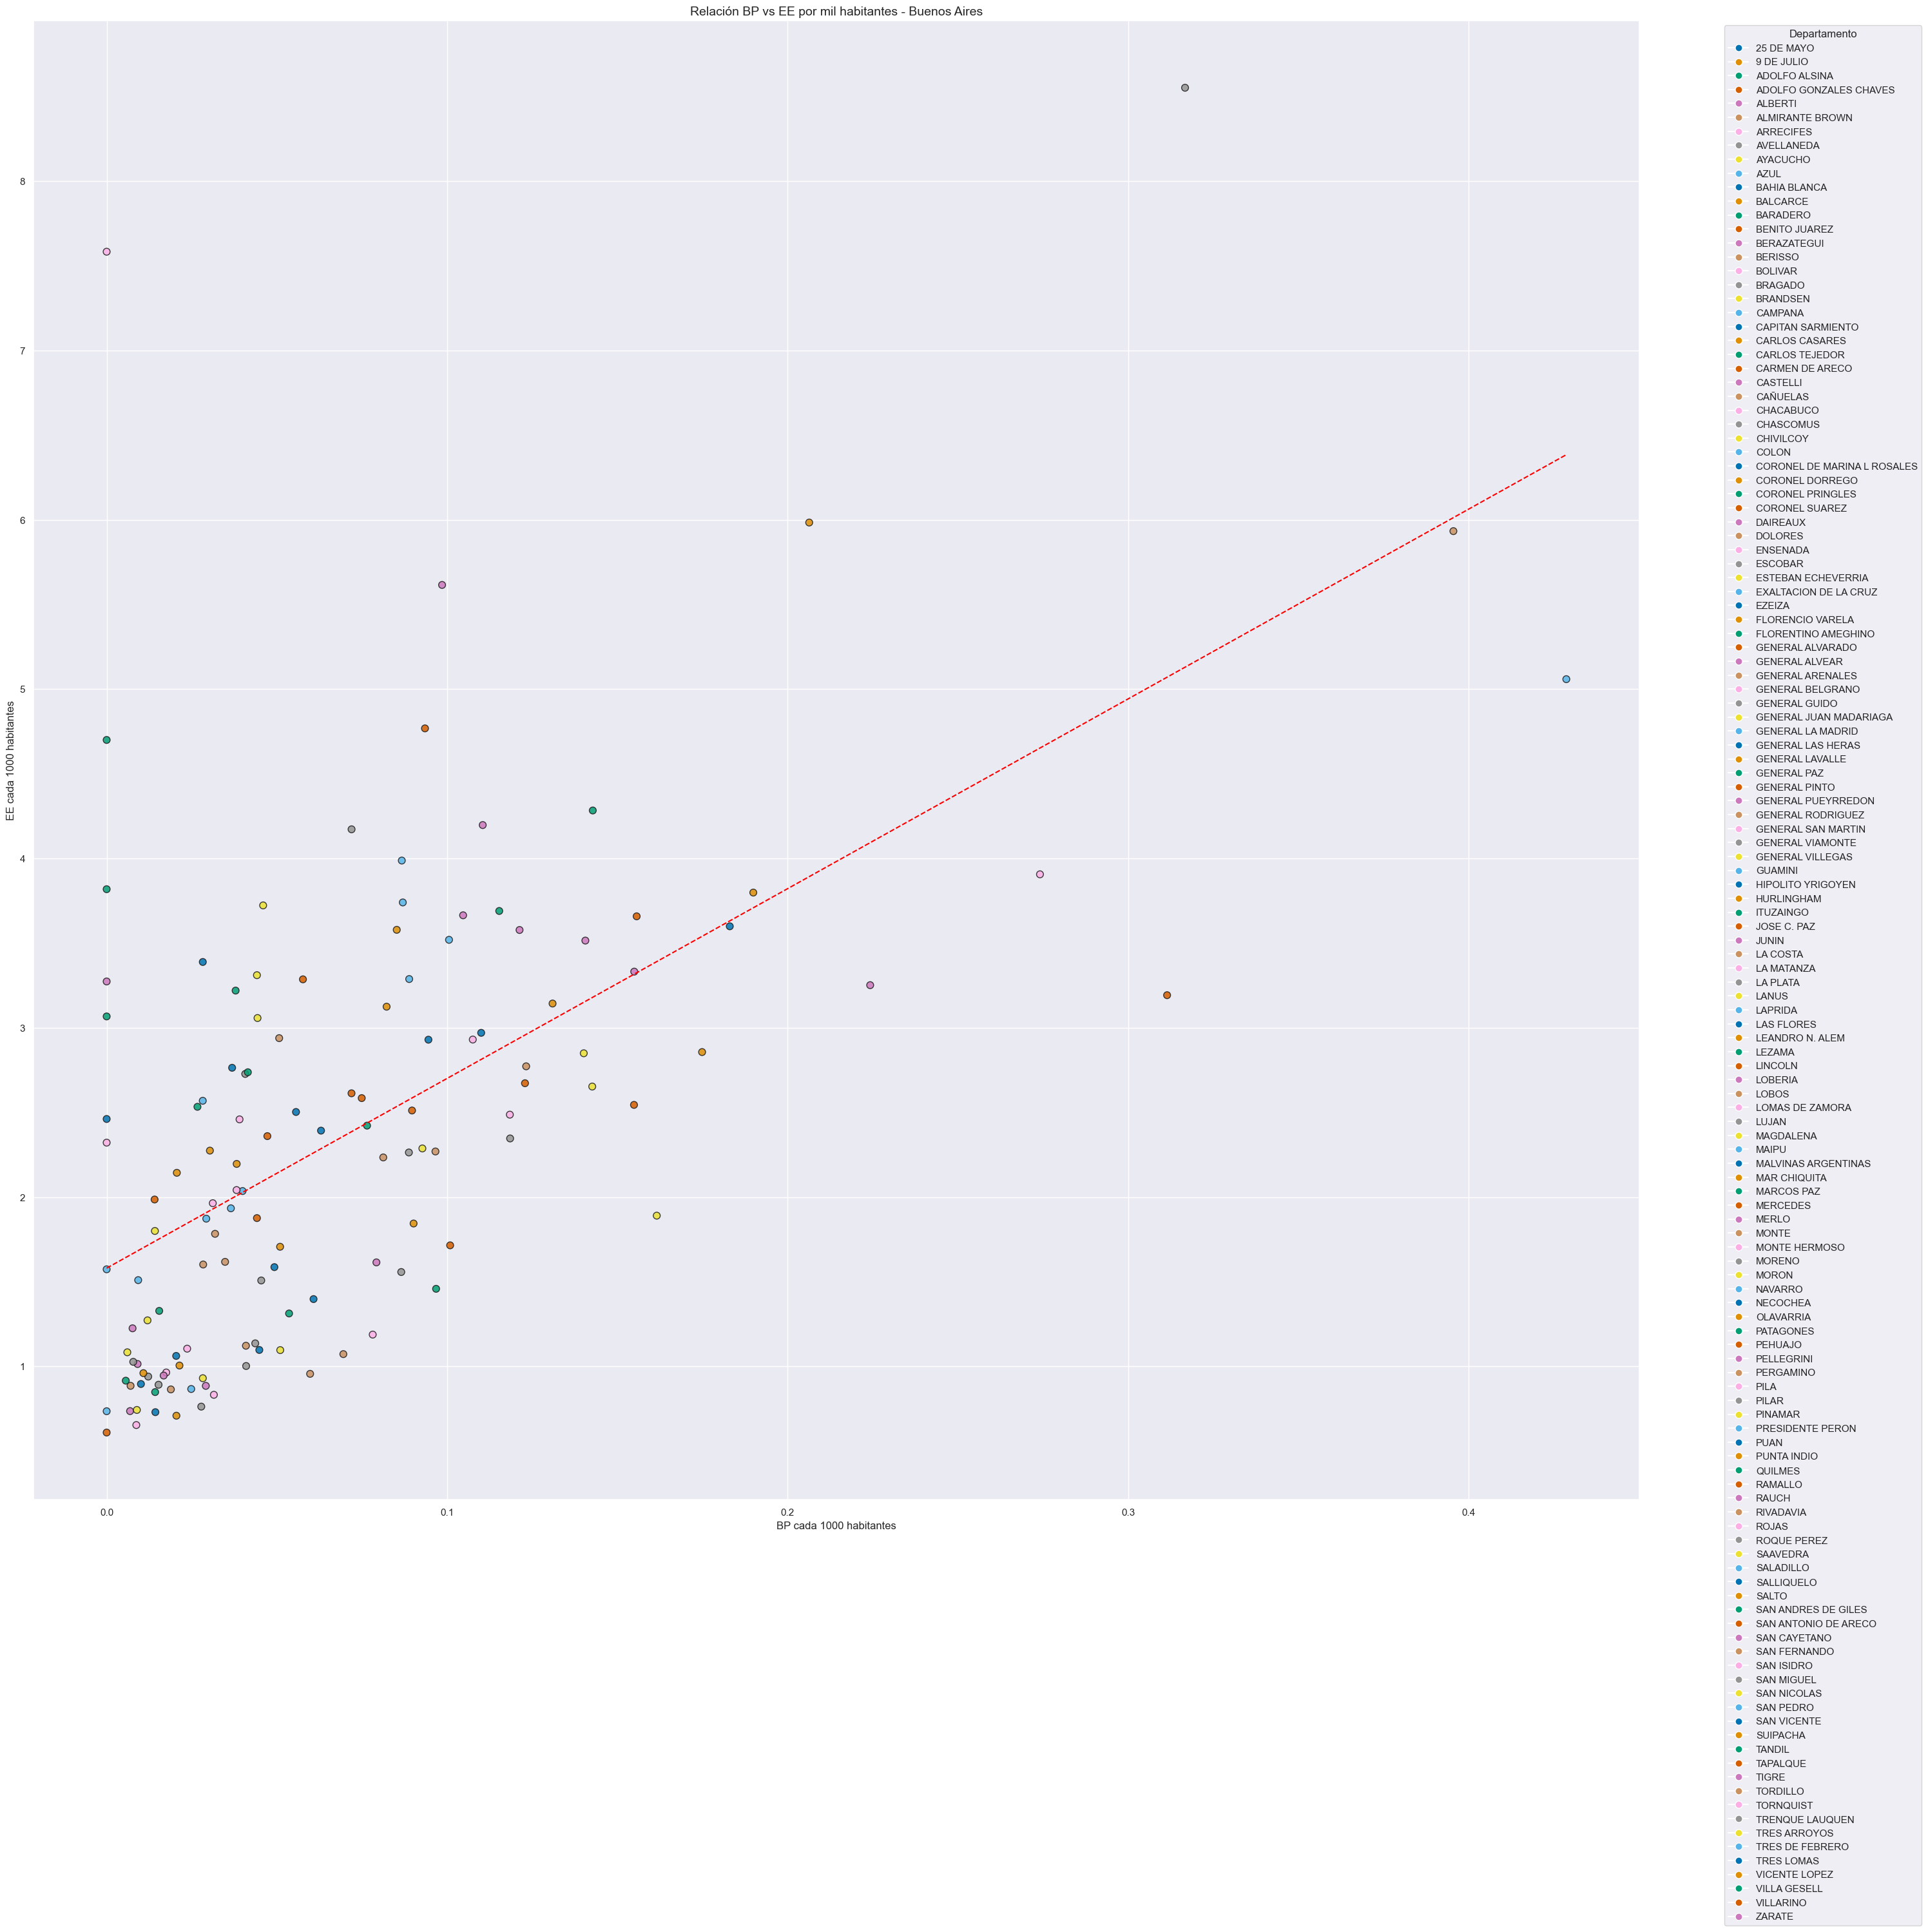

In [15]:
provincia = "Buenos Aires"                                                      # Nuevamente cambiando el nombre de la provincia podemos ver su 
                                                                                # respectivo grafico

consulta_3["bp_por_mil"] = consulta_3["cantidad_bp"] / consulta_3["poblacion_total"] * 1000     # Calculamos los valores para la provincia
consulta_3["ee_por_mil"] = consulta_3["cantidad_ee"] / consulta_3["poblacion_total"] * 1000
consulta_3.columns = [col.strip().lower() for col in consulta_3.columns]

datos = consulta_3[consulta_3["provincia"] == provincia].copy()

# Colores únicos por departamento (colorblind-friendly)
departamentos = datos["departamento"].astype("category")                                        # Agregamos colores únicos por departamento 
datos["color_code"] = departamentos.cat.codes                                                   # con una paleta colorblind-friendly
palette = sns.color_palette("colorblind", len(departamentos.cat.categories))
colors = [palette[i] for i in datos["color_code"]]

if provincia == "Buenos Aires":                                                 # Ajustamos medidas sobre todo para el caso de la provincia de Buenos Aires
    plt.figure(figsize=(30, 30))
else:
    plt.figure(figsize=(10, 7))
plt.scatter(datos["bp_por_mil"], datos["ee_por_mil"], c=colors, s=60, edgecolors='k', alpha=0.85)

plt.xlabel("BP cada 1000 habitantes", fontsize=12)                              # Nombramos los ejes XY de nuestro grafico
plt.ylabel("EE cada 1000 habitantes", fontsize=12)
plt.title(f"Relación BP vs EE por mil habitantes - {provincia}", fontsize=14)


x = datos["bp_por_mil"]                                                         # Utilizamos regresion lineal para facilitar el analisis de la tendencia
y = datos["ee_por_mil"]
if x.nunique() > 1 and y.nunique() > 1:
    coef = np.polyfit(x, y, 1)
    poly = np.poly1d(coef)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = poly(x_line)
    plt.plot(x_line, y_line, color="red", linestyle="--", label="Regresión lineal")


nombres_deptos = [Line2D([0], [0], marker='o', color='w', label=depto,           # Creamos las etiquetas para los nombres de los departamentos
                  markerfacecolor=palette[i], markersize=8)
           for i, depto in enumerate(departamentos.cat.categories)]
plt.legend(handles=nombres_deptos, bbox_to_anchor=(1.05, 1), loc='upper left', title="Departamento")

plt.tight_layout()
plt.grid(True)
plt.show()

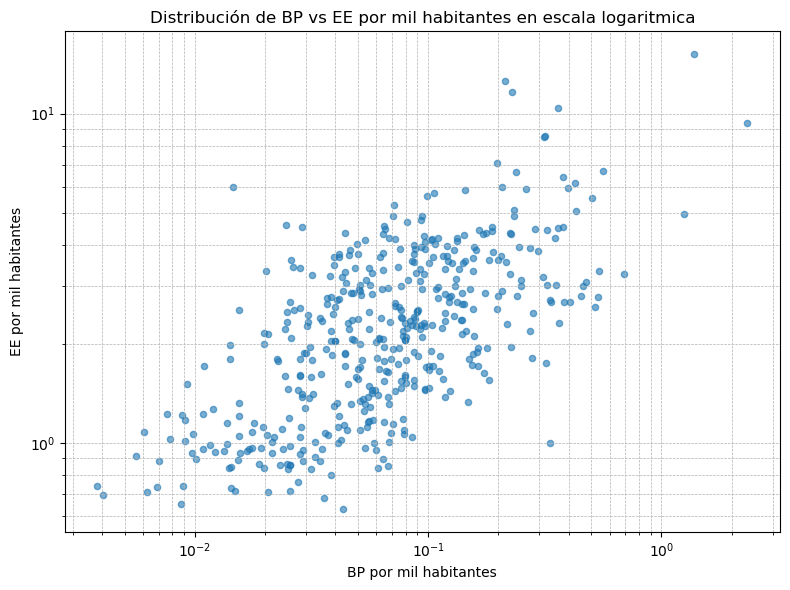

In [ ]:
consulta_3_log = consulta_3[(consulta_3['bp_por_mil'] > 0) & (consulta_3['ee_por_mil'] > 0)].copy()     # La mayoria de los datos los teniamos de antes


plt.figure(figsize=(8, 6))                                                                              # Graficamos la cantidad de BPs y EEs cada 
plt.scatter(consulta_3_log['bp_por_mil'], consulta_3_log['ee_por_mil'], alpha=0.6, s=20)                # 1000 habitantes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('BP por mil habitantes')
plt.ylabel('EE por mil habitantes')
plt.title('Distribución de BP vs EE por mil habitantes en escala logaritmica')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.tight_layout()
plt.show()